# Comparing Various Ordinal Embedding Algorithms

In [1]:
import time
import FORTE.utils as utils
from FORTE.algorithms import NuclearNormProjected, FactoredGradient
import blackbox
import numpy as np
import matplotlib.pyplot as plt

First, to demonstrate the basic idea of embedding from triplet data, we generate a true centered set of points `Xtrue` in two dimensions and using just ordinal information about `Xtruue`, find a set of points satisfying the same ordinal constraints.

A triplet is a three tuple (i,j,k) which represents that X_i is closer to X_j than X_k. We add 10*nd*log(n) such triplets to the training set, `Strain`, and the same number to a test set `Stest`. 

In [2]:
n = 30
d = 2
num_triplets = 20*d*n*np.log(n)

Xtrue = np.random.randn(n, d)
Xtrue = Xtrue - 1. / n * np.dot(np.ones((n, n)),  Xtrue)
Mtrue = np.dot(Xtrue, Xtrue.transpose())

# Train and test set
Strain = utils.triplets(Xtrue, num_triplets)
Stest = utils.triplets(Xtrue, num_triplets)

We now use the `FactoredGradient`  algorithm to find an embedding `Xhat` that agrees with these triplets. A Procrustes transformation is used to align `Xhat` with `Xtrue`. This may take a few seconds to run.

In [3]:
Xhat = FactoredGradient.computeEmbedding(n, d, Strain,
                                         num_random_restarts=0,
                                         max_num_passes_SGD=16, max_iter_GD=50,
                                         max_norm=1, epsilon=0.01, verbose=False)
print ('Empirical Training loss = {},' 
       'Empirical Test loss = {}').format(utils.empirical_lossX(Xhat, Strain),
                                          utils.empirical_lossX(Xhat, Stest))
                                       

Empirical Training loss = 0.0166625827003,Empirical Test loss = 0.0227885322225


Finally we use a Procrustes transformation to align `Xtrue` with `Xhat` and plot the resulting embeddings.

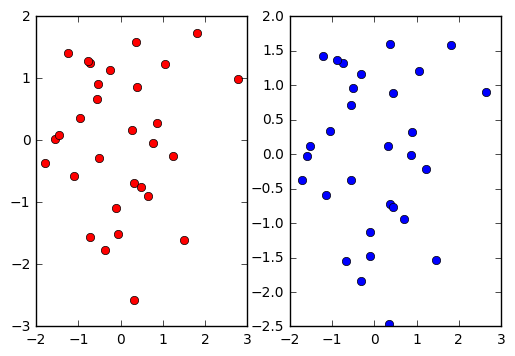

In [4]:
_, Xpro, _ = utils.procrustes(Xtrue, Xhat)
plt.figure(1)
plt.subplot(121); plt.plot(*zip(*Xtrue), marker='o', color='r', ls='')
plt.subplot(122); plt.plot(*zip(*Xpro), marker='o', color='b', ls='')
plt.show()


Now that we see how basic embedding works, we will compare the various embedding algorithms in the `FORTE` package to understand 

a) Their accuracy at embedding.
b) Their average run-time. 
c) 